### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Get Data

In [2]:
train = pd.read_hdf('../wip-data/train.h5')
SalePrice = pd.read_hdf('../wip-data/SalePrice.h5')

### Investigating Heteroscedacity

To identify heteroscedacity of the dependent variable, <code>SalePrice</code>, we fit a <b>Support Vector Regression</b> model, with both, a <i>polynomial</i> and a <i>rbf</i> kernel, to the <i>train</i> dataset. We use the resulting model to predict values for the depended variable, <code>SalePrice_hat</code>, calculate the residuals and then plot the studentized residuals versus the values of <code>SalePrice</code>. Additionally we also plot the Q-Q plot for the studentized residuals. The shape of the resulting plots are a strong indicator of the presence of heteroscedacity.

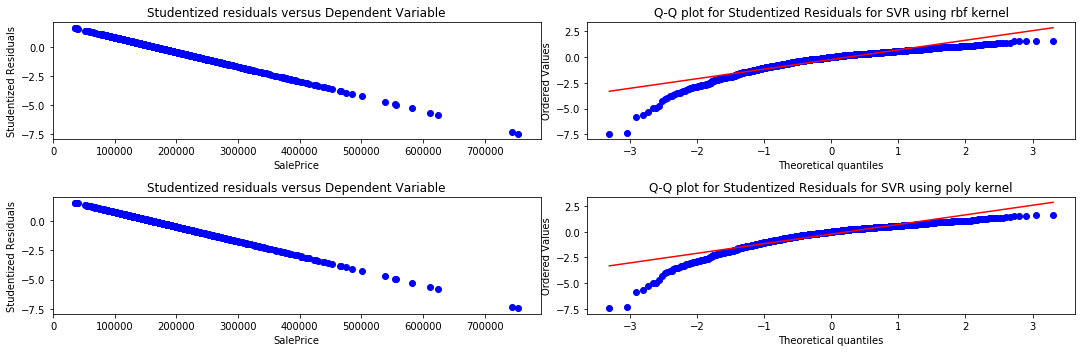

In [10]:
from sklearn.svm import SVR
import scipy.stats as stats

kernels = ['rbf', 'poly']

plt.figure(figsize = (15, 5))
i = 1

for kernel in kernels:
    svr = SVR(kernel = kernel).fit(train, SalePrice)
    SalePrice_hat = svr.predict(train)
    res = (SalePrice_hat - SalePrice)/np.std(SalePrice_hat - SalePrice)
    
    plt.subplot(2, 2, i)
    i += 1
    plt.scatter(SalePrice, res, color = 'blue')
    plt.xlabel('SalePrice')
    plt.ylabel('Studentized Residuals')
    plt.title('Studentized residuals versus Dependent Variable')
    
    plt.subplot(2, 2, i)
    i += 1
    stats.probplot(res, dist = 'norm', plot = plt)
    plt.title('Q-Q plot for Studentized Residuals for SVR using %s kernel' % kernel)

plt.tight_layout()
plt.show()

The plots in the right column confirm that for SVR with either kernels,  the values of the studentized residuals significantly vary from the theoretical normal distribution starting earlier than (+)(-) 2<i>sigma</i>. This is a strong indicator that the train dataset is heteroscedastic.

To eliminate this heteroscedacity, we transform the dependent variable to its log value, fit a linear model to this new dependent variable and then check if this transformation helps eliminate the heteroscedacity by plotting the values of the new studentized residuals to the values of the new dependent variable.


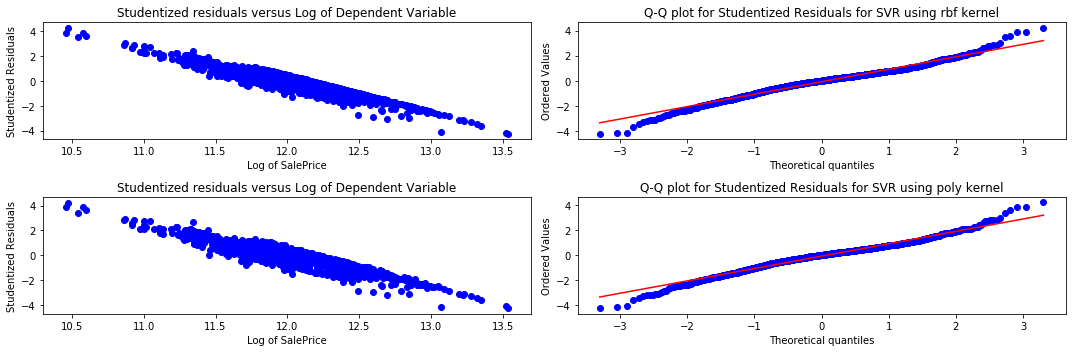

In [11]:
plt.figure(figsize = (15, 5))
i = 1
SalePrice_log = np.log(SalePrice)

for kernel in kernels:
    svr = SVR(kernel = kernel).fit(train, SalePrice_log)
    SalePrice_log_hat = svr.predict(train)
    res = (SalePrice_log_hat - SalePrice_log)/np.std(SalePrice_log_hat - SalePrice_log)
    
    plt.subplot(2, 2, i)
    i += 1
    plt.scatter(SalePrice_log, res, color = 'blue')
    plt.xlabel('Log of SalePrice')
    plt.ylabel('Studentized Residuals')
    plt.title('Studentized residuals versus Log of Dependent Variable')
    
    plt.subplot(2, 2, i)
    i += 1
    stats.probplot(res, dist = 'norm', plot = plt)
    plt.title('Q-Q plot for Studentized Residuals for SVR using %s kernel' % kernel)

plt.tight_layout()
plt.show()

The log transformation does help eliminate heteroscedacity in the <i>train</i> dataset. The plots in the right column show deviations for actual values from the theoretical quantiles well after (+)(-)2<i>sigma</i>.

### Investigating <i>Bias</i> versus <i>Variance</i> tradeoff

For both kernels, we investigate the <i>Bias</i> versus <i>Variance</i> tradeoff for the resulting models buy plotting the respective learning curves.

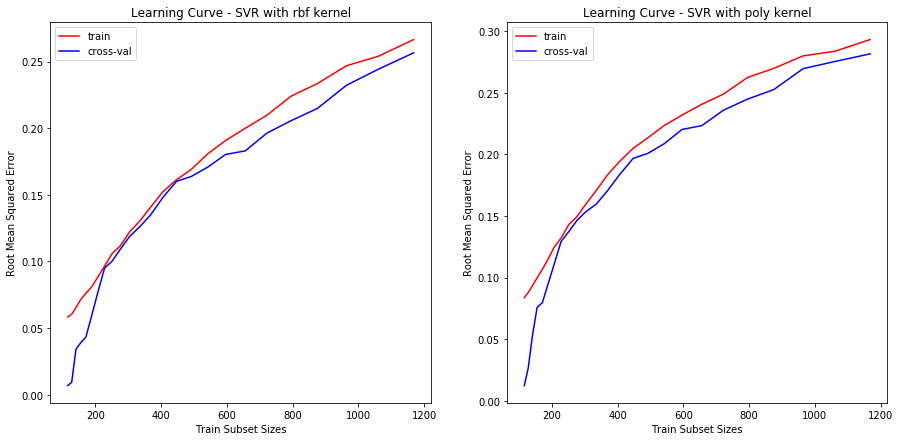

In [73]:
from sklearn.model_selection import learning_curve

plt.figure(figsize = (15, 7))
i = 1

for kernel in kernels:
    svr = SVR(kernel = kernel, max_iter = -1)
    train_sizes, train_scores, val_scores = learning_curve(estimator = svr, X = train, y = SalePrice_log, 
                                                           train_sizes = np.logspace(-1, 0, 25), shuffle = True,
                                                           scoring = 'r2', 
                                                           random_state = 1970)
    plt.subplot(1, 2, i)
    i += 1
    plt.plot(train_sizes, train_scores.mean(axis = 1), label = 'train', color = 'red')
    plt.plot(train_sizes, val_scores.mean(axis = 1), label = 'cross-val', color = 'blue')
    plt.xlabel('Train Subset Sizes')
    plt.ylabel('Root Mean Squared Error')
    plt.title('Learning Curve - SVR with %s kernel' % kernel)
    plt.legend()

plt.show()

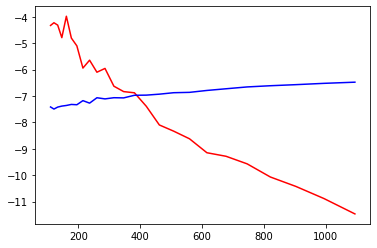

In [72]:
### Building the Learning Curve from scratch

X_train, X_val, y_train, y_val = train_test_split(train, SalePrice_log, train_size = 0.75)
train_sizes = np.logspace(-1, 0, 25)*X_train.shape[0]
train_scores = []
val_scores = []

for size in train_sizes:
    index = np.random.choice(X_train.shape[0], int(size), replace = False)
    model = SVR().fit(X_train.iloc[index, :], y_train.iloc[index])
    train_score = -np.mean(sum((model.predict(X_train.iloc[index, :]) - y_train.iloc[index])**2))**(1/2)
    train_scores.append(train_score)
    val_score = -np.mean(sum((model.predict(X_val) - y_val)**2))**(1/2)
    val_scores.append(val_score)

plt.figure()
plt.plot(train_sizes, train_scores, color = 'red')
plt.plot(train_sizes, val_scores, color = 'blue')
plt.show()

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_val, y_train, y_val = train_test_split(train, SalePrice_log, random_state = 1970)

grid = []
model = GridSearchCV(SVR(), param_grid = grid)

model.get_params()


{'cv': None,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__cache_size': 200,
 'estimator__coef0': 0.0,
 'estimator__degree': 3,
 'estimator__epsilon': 0.1,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
     kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
 'iid': 'deprecated',
 'n_jobs': None,
 'param_grid': [],
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}